<a href="https://colab.research.google.com/github/GabCopetti/Chest-X-Rays-Binary-Classification/blob/main/Chest_XRays_Training_and_Evaluation_BatchSize64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Motivation**: Following the experiment perform in the notebook *Chest_XRays_Training_BatchSize32*, some models were retrained using a bigger batch size to increase model stability.

***
## 1. Setting up environment
***

In [1]:
#Installing specific Python version
!sudo apt-get install python3.10
!python --version

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.10 is already the newest version (3.10.12-1~22.04.5).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Python 3.10.12


In [2]:
#Installing necessary packages

#Disabling output
%%capture
!pip install torch==2.3.1+cu121
!pip install torchvision==0.18.1+cu121
!pip install datasets==2.20.0
!pip install matplotlib==3.7.1
!pip install requests==2.32.3
!pip install torchmetrics==1.4.0.post0
!pip install tqdm==4.66.4
!pip install sklearn==2.2.0

In [3]:
#Importing libraries

#Torch
import torch
from torch import nn

#Torchvision
import torchvision
from torchvision.transforms import functional as F

#Import datasets from Hugging Face
import datasets
from datasets import load_dataset

#Matplotlib
import matplotlib.pyplot as plt

#Importing Path to download helper functions from Learn PyTorch repo
import requests
from pathlib import Path

#Importing DataLoader
from torch.utils.data import DataLoader

#Importing tqdm for progress bar
from tqdm.auto import tqdm

#To use in the plotting function
from typing import Dict, List

#For evaluation
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay


In [4]:
# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [5]:
#Import accuracy metric
from helper_functions import accuracy_fn

In [6]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

***
## 2. Data preparation
***

In [50]:
#Loading datasets
train_dataset = load_dataset("keremberke/chest-xray-classification", "full", split="train")
valid_dataset = load_dataset("keremberke/chest-xray-classification", "full", split="validation")
test_dataset = load_dataset("keremberke/chest-xray-classification", "full", split="test")

In [51]:
train_dataset[0]

{'image_file_path': '/storage/hf-datasets-cache/all/datasets/60340657865253-config-parquet-and-info-keremberke-chest-xray-cla-9d66ea8b/downloads/extracted/8202f7dd6f1edf5e674abe75990eb233fbbca4408e132a3acd5268bd99708e15/NORMAL/IM-0003-0001_jpeg.rf.3fffcf9c33575f8f928b017484f99a64.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 'labels': 0}

In [52]:
#Changing format to torch.Tensor and losing image_file_path
format = {'type': 'torch', 'device': torch.device(device), 'columns': ['image','labels'], 'format_kwargs':{'dtype': torch.float}}
train_dataset.set_format(**format )
valid_dataset.set_format(**format )
test_dataset.set_format(**format )

In [53]:
train_dataset[0]

{'image': tensor([[[  0.,  28.,  39.,  ..., 107., 107.,  40.],
          [  0.,  28.,  39.,  ..., 107., 107.,  40.],
          [  0.,  28.,  39.,  ..., 106., 107.,  40.],
          ...,
          [  1.,  27.,  40.,  ...,  34.,  32.,  14.],
          [  1.,  27.,  40.,  ...,  34.,  32.,  14.],
          [  1.,  27.,  40.,  ...,  34.,  32.,  14.]],
 
         [[  0.,  28.,  39.,  ..., 107., 107.,  40.],
          [  0.,  28.,  39.,  ..., 107., 107.,  40.],
          [  0.,  28.,  39.,  ..., 106., 107.,  40.],
          ...,
          [  1.,  27.,  40.,  ...,  34.,  32.,  14.],
          [  1.,  27.,  40.,  ...,  34.,  32.,  14.],
          [  1.,  27.,  40.,  ...,  34.,  32.,  14.]],
 
         [[  0.,  28.,  39.,  ..., 107., 107.,  40.],
          [  0.,  28.,  39.,  ..., 107., 107.,  40.],
          [  0.,  28.,  39.,  ..., 106., 107.,  40.],
          ...,
          [  1.,  27.,  40.,  ...,  34.,  32.,  14.],
          [  1.,  27.,  40.,  ...,  34.,  32.,  14.],
          [  1.,  27.,

In [54]:
train_dataset[0]['image'].shape

torch.Size([3, 640, 640])

In [55]:
def transform(example):
    #Transforming channel number = 3 to channnel number = 1
    example['image'] = F.rgb_to_grayscale(example['image'], num_output_channels=1)
    #Converting pixel values from 0-255 to 0-1
    example['image'] = example['image']/255
    return example

In [56]:
#Applying transformations to sets
train_dataset = train_dataset.map(transform, batched= True, batch_size=32)
valid_dataset = valid_dataset.map(transform, batched= True, batch_size=32)
test_dataset = test_dataset.map(transform, batched= True, batch_size=32)

Map:   0%|          | 0/582 [00:00<?, ? examples/s]

In [57]:
train_dataset[0]

{'image': tensor([[[0.0000, 0.1098, 0.1529,  ..., 0.4196, 0.4196, 0.1568],
          [0.0000, 0.1098, 0.1529,  ..., 0.4196, 0.4196, 0.1568],
          [0.0000, 0.1098, 0.1529,  ..., 0.4156, 0.4196, 0.1568],
          ...,
          [0.0039, 0.1059, 0.1568,  ..., 0.1333, 0.1255, 0.0549],
          [0.0039, 0.1059, 0.1568,  ..., 0.1333, 0.1255, 0.0549],
          [0.0039, 0.1059, 0.1568,  ..., 0.1333, 0.1255, 0.0549]]],
        device='cuda:0'),
 'labels': tensor(0., device='cuda:0')}

In [58]:
train_dataset[0]['image'].shape

torch.Size([1, 640, 640])

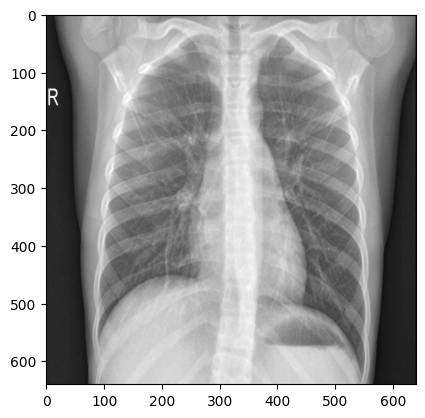

In [59]:
#Checking if image is unchanged after transformation
plt.imshow(train_dataset[0]['image'].squeeze().cpu(), cmap='gray')

In [60]:
#Setting up DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 64

# Turn datasets into iterables (batches)
train_dataloader = DataLoader((train_dataset), # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

valid_dataloader = DataLoader((valid_dataset),
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the validation data
)

test_dataloader = DataLoader((test_dataset),
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the validation data
)

print(f"Dataloaders: {train_dataloader, valid_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of validation dataloader: {len(valid_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x79e93a505f90>, <torch.utils.data.dataloader.DataLoader object at 0x79e93a506b30>, <torch.utils.data.dataloader.DataLoader object at 0x79e93a507190>)
Length of train dataloader: 64 batches of 64
Length of validation dataloader: 19 batches of 64
Length of test dataloader: 10 batches of 64


***
## 3. Defining functions (loss, training, validation, testing)
***

In [61]:
# Set up loss functions

# Without weight
loss_fn = nn.BCEWithLogitsLoss()

# With weight to take into account class imbalance
# pos_weight = 0/1 ratio = 0.37
loss_fn_weighed = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([0.37]).to(device))

In [62]:
# Set up train, validation and testing steps

#Train
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    #List to store true values and predictions
    y_true_list = []
    y_pred_list = []
    #Loss and accuracy variables
    train_loss, train_acc = 0, 0

    #Put model in train mode
    model.to(device)
    model.train()

    #Loop through batches
    for batch, entry in enumerate(data_loader):
        X = entry['image'].to(device)
        y = entry['labels'].to(device)
        y_true_list.append(y)

        # 1. Forward pass
        y_logits = model(X).squeeze().to(device) # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
        y_pred = torch.round(torch.sigmoid(y_logits)).to(device)
        with torch.no_grad():
            y_pred_list.append(y_pred)

        # 2. Calculate loss
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 32 == 0:
            print(f"Looked at {batch * len(X)}/{len(data_loader.dataset)} samples")

    # Calculate loss, accuracy and f1 score per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    y_true_list = torch.cat(y_true_list).detach().cpu().numpy()
    y_pred_list = torch.cat(y_pred_list).detach().cpu().numpy()
    train_f1 = f1_score(y_true_list, y_pred_list)

    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}% | Train F1: {train_f1:.2f}")
    return train_loss, train_acc, train_f1


#Validation step
def valid_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    y_true_list = []
    y_pred_list = []
    valid_loss, valid_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for entry in data_loader:
            # Send data to GPU
            X = entry['image'].to(device)
            y = entry['labels'].to(device)
            y_true_list.append(y)

            # 1. Forward pass
            valid_logits = model(X).squeeze().to(device)
            valid_pred = torch.round(torch.sigmoid(valid_logits)).to(device)
            y_pred_list.append(valid_pred)

            # 2. Calculate loss and accuracy
            valid_loss += loss_fn(valid_logits, y).item()
            valid_acc += accuracy_fn(y_true=y, y_pred=valid_pred)

        # Adjust metrics and print out
        valid_loss /= len(data_loader)
        valid_acc /= len(data_loader)
        y_true_list = torch.cat(y_true_list).cpu()
        y_pred_list = torch.cat(y_pred_list).cpu()
        valid_f1 = f1_score(y_true_list, y_pred_list)
        print(f"Validation loss: {valid_loss:.5f} | Validation accuracy: {valid_acc:.2f}%\n | Validation F1: {valid_f1:.2f}")
        return valid_loss, valid_acc, valid_f1


#Testing step
def test(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    y_true = []
    y_pred = []
    test_acc, test_f1 = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for entry in data_loader:
            # Send data to GPU
            X = entry['image'].to(device)
            y = entry['labels'].to(device)
            y_true.append(y)

            # 1. Forward pass
            test_logits = model(X).squeeze().to(device)
            test_pred = torch.round(torch.sigmoid(test_logits)).to(device)
            y_pred.append(test_pred)

            # 2. Calculate accuracy
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred)

        # Adjust metrics and return
        y_true = torch.cat(y_true).to('cpu')
        y_true = torch.Tensor.numpy(y_true)
        y_pred = torch.cat(y_pred).to('cpu')
        y_pred = torch.Tensor.numpy(y_pred)
        test_acc /= len(data_loader)
        test_f1 += f1_score(y_true=y_true, y_pred=y_pred)

        results = {
            "test_acc": test_acc,
            "test_f1": test_f1
        }

        return results, y_true, y_pred

In [63]:
torch.manual_seed(42)

# 1. Take in various parameters required for training and validation steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          valid_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int = 5):

    # Create empty results dictionary
    results = {"train_loss": [],
            "train_acc": [],
            "train_f1": [],
            "valid_loss": [],
            "valid_acc": [],
            "valid_f1": []
              }

    # Train and validate model
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}\n---------")
        train_loss, train_acc, train_f1 = train_step(data_loader=train_dataloader,
                                        model=model,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        accuracy_fn=accuracy_fn,
                                        device=device
                                        )
        valid_loss, valid_acc, valid_f1 = valid_step(data_loader=valid_dataloader,
                                    model=model,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device=device
                                    )
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_f1"].append(train_f1)
        results["valid_loss"].append(valid_loss)
        results["valid_acc"].append(valid_acc)
        results["valid_f1"].append(valid_f1)

    # Return the filled results at the end of the epochs
    return results

***
## 4. Function to plot loss and accuracy graphs
***

In [21]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "valid_loss": [...],
             "valid_acc": [...]}
             "train_f1": [...],
             "valid_f1": [...]}
    """

    # Get the loss values of the results dictionary (training and validation)
    loss = results['train_loss']
    valid_loss = results['valid_loss']

    # Get the accuracy values of the results dictionary (training and validation)
    accuracy = results['train_acc']
    valid_accuracy = results['valid_acc']

    # Get the f1 values of the results dictionary (training and validation)
    f1 = torch.tensor(results['train_f1']).detach().cpu().numpy()
    valid_f1 = torch.tensor(results['valid_f1']).detach().cpu().numpy()

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 15))

    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, valid_loss, label='valid_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, valid_accuracy, label='valid_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

    # Plot F1
    plt.subplot(2, 2, 3)
    plt.plot(epochs, f1, label='train_f1')
    plt.plot(epochs, valid_f1, label='valid_f1')
    plt.title('F1')
    plt.xlabel('Epochs')
    plt.legend();

***
## 5. Setting up model classes
***

### Linear models

In [22]:
#Two linear layers
class XRAYS_linear2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flattens inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [23]:
#Three linear layers
class XRAYS_linear3(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flattens inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [24]:
#Four linear layers
class XRAYS_linear4(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flattens inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

### Non-linear models

In [25]:
# Two layers
class XRAYS_linear2ReLU(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flattens inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(), #adds non-linearity
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU() #adds non-linearity
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [26]:
# Three layers
class XRAYS_linear3ReLU(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(), #adds non-linearity
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), #adds non-linearity
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU() #adds non-linearity
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [27]:
# Four layers
class XRAYS_linear4ReLU(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(), #adds non-linearity
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), #adds non-linearity
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), #adds non-linearity
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU() #adds non-linearity
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)


### Convolutional Neural Networks

In [28]:
# Create a convolutional neural network

#One linear layer at the end

class XRAYS_CNN(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*25600,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [29]:
class XRAYS_CNN_Kernel_Size_5(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=5, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=5,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 5, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 5, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*24649,
                      out_features=output_shape)

        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

## 6. Experiment

***
###  a. Loss function not weighed
***

#### Setting up models

In [ ]:
#Linear
torch.manual_seed(42)

# Number of linear layers: 2
# Number of hidden units: 10
model_20b = XRAYS_linear2(input_shape=409600, # one for every pixel
    hidden_units=10, # how many units in the hidden layer
    output_shape=1
)
model_20b.to(device)

XRAYS_linear2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [ ]:
optimizer_20b = torch.optim.SGD(params=model_20b.parameters(), lr=0.0001)

In [ ]:
# Linear + ReLU
torch.manual_seed(42)

# Number of linear layers: 2
# Number of hidden units: 10
model_21b = XRAYS_linear2ReLU(input_shape=409600, # one for every pixel
    hidden_units=10, # how many filters
    output_shape=1
)
model_21b.to(device)

XRAYS_linear2ReLU(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=1, bias=True)
    (4): ReLU()
  )
)

In [ ]:
optimizer_21b = torch.optim.SGD(params=model_21b.parameters(), lr=0.0001)

In [ ]:
# CNN
torch.manual_seed(42)

# Kernel size 3x3
# Number of hidden units: 10
model_22b = XRAYS_CNN(input_shape=1, # 1 colour channel
    hidden_units=10, # number of filters
    output_shape=1
)
model_22b.to(device)

XRAYS_CNN(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256000, out_features=1, bias=True)
  )
)

In [ ]:
optimizer_22b = torch.optim.SGD(params=model_22b.parameters(), lr=0.01)

#### Training

In [ ]:
#Set number of epochs
NUM_EPOCHS = 60

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Linear
# Number of linear layers: 2
# Number of hidden units: 10
# Train model
model_20b_results = train(model=model_20b,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_20b,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.52429 | Train accuracy: 73.74% | Train F1: 0.85
Validation loss: 0.43669 | Validation accuracy: 76.07%
 | Validation F1: 0.86
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.42939 | Train accuracy: 79.90% | Train F1: 0.88
Validation loss: 0.37690 | Validation accuracy: 79.28%
 | Validation F1: 0.87
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.37475 | Train accuracy: 84.72% | Train F1: 0.90
Validation loss: 0.32978 | Validation accuracy: 88.82%
 | Validation F1: 0.93
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.34266 | Train accuracy: 87.20% | Train F1: 0.92
Valida

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Linear + ReLU
# Number of linear layers: 2
# Number of hidden units: 10
# Train model
model_21b_results = train(model=model_21b,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_21b,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.55687 | Train accuracy: 72.93% | Train F1: 0.84
Validation loss: 0.49317 | Validation accuracy: 75.00%
 | Validation F1: 0.85
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.48808 | Train accuracy: 73.99% | Train F1: 0.85
Validation loss: 0.43956 | Validation accuracy: 75.58%
 | Validation F1: 0.85
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.44500 | Train accuracy: 76.54% | Train F1: 0.86
Validation loss: 0.40619 | Validation accuracy: 80.26%
 | Validation F1: 0.88
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.41992 | Train accuracy: 79.27% | Train F1: 0.88
Valida

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# CNN
# Kernel size 3x3
# Number of hidden units: 5
# Train model
model_22b_results = train(model=model_22b,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_22b,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.58304 | Train accuracy: 72.71% | Train F1: 0.84
Validation loss: 0.51662 | Validation accuracy: 75.00%
 | Validation F1: 0.85
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.43043 | Train accuracy: 80.11% | Train F1: 0.87
Validation loss: 0.36589 | Validation accuracy: 81.25%
 | Validation F1: 0.88
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.28901 | Train accuracy: 88.22% | Train F1: 0.92
Validation loss: 0.19314 | Validation accuracy: 93.51%
 | Validation F1: 0.96
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.23216 | Train accuracy: 90.52% | Train F1: 0.94
Valida

#### Results

In [ ]:
# Linear
# Number of linear layers: 2
# Number of hidden units: 10
model_20b_results

{'train_loss': [0.5242916466668248,
  0.42938875779509544,
  0.3747535552829504,
  0.342663450865075,
  0.3179128458723426,
  0.2985536514315754,
  0.2839678858872503,
  0.27503406000323594,
  0.2666654291097075,
  0.2587174822110683,
  0.2484591139946133,
  0.24365930631756783,
  0.23959384276531637,
  0.23490959638729692,
  0.23000439256429672,
  0.22707141330465674,
  0.22159224143251777,
  0.2204882581718266,
  0.21597232832573354,
  0.2130721532739699,
  0.21162392816040665,
  0.20988116110675037,
  0.20732447761110961,
  0.20541212102398276,
  0.20293209876399487,
  0.20052707253489643,
  0.19990902242716402,
  0.19857027498073876,
  0.19556755758821964,
  0.19580055004917085,
  0.1937612174078822,
  0.1915235788328573,
  0.19123610365204513,
  0.18910117098130286,
  0.1889474947238341,
  0.18832268950063735,
  0.18507580610457808,
  0.187015195726417,
  0.18467246310319752,
  0.1833214209182188,
  0.18255276116542518,
  0.1827519218204543,
  0.1804951288504526,
  0.1797363215591

In [ ]:
# Linear + ReLU
# Number of linear layers: 2
# Number of hidden units: 10
model_21b_results

{'train_loss': [0.556866223923862,
  0.4880792982876301,
  0.4450038350187242,
  0.41992128919810057,
  0.4001988237723708,
  0.38350639771670103,
  0.37243163399398327,
  0.3656877095345408,
  0.3593876287341118,
  0.35413905628956854,
  0.34545978996902704,
  0.3426166025456041,
  0.3395962296053767,
  0.33626833697780967,
  0.3333411051426083,
  0.3302689674310386,
  0.32702208147384226,
  0.3262811847962439,
  0.3231909980531782,
  0.3208844419568777,
  0.31954369484446943,
  0.3184672184288502,
  0.316972941160202,
  0.315015803091228,
  0.31427535391412675,
  0.3120493139140308,
  0.3113692165352404,
  0.31073871394619346,
  0.30829340778291225,
  0.3080752701498568,
  0.3073544150684029,
  0.305296428501606,
  0.3050660095177591,
  0.3042372614145279,
  0.30392399756237864,
  0.3029933371581137,
  0.3019133140332997,
  0.30281786108389497,
  0.3010332053527236,
  0.3002895903773606,
  0.29920703126117587,
  0.29918157565407455,
  0.2979939542710781,
  0.29777315934188664,
  0.29

In [ ]:
# CNN
# Kernel size 3x3
# Number of hidden units: 10
model_22b_results

{'train_loss': [0.5830375719815493,
  0.4304252527654171,
  0.2890129112638533,
  0.232159000239335,
  0.19315134908538312,
  0.18220667622517794,
  0.172326396452263,
  0.1694374023936689,
  0.16126418637577444,
  0.1934984060935676,
  0.14854633290087804,
  0.14558378292713314,
  0.14143249281914905,
  0.13847259082831442,
  0.13596762239467353,
  0.13842588191619143,
  0.1330145443789661,
  0.13343851355602965,
  0.1229587220295798,
  0.11680580535903573,
  0.1225173442508094,
  0.11667850863886997,
  0.11712540182634257,
  0.11344500462291762,
  0.12090358627028763,
  0.11879762820899487,
  0.10878615686669946,
  0.1113609170424752,
  0.10343906028720085,
  0.10387549578445032,
  0.1054118902538903,
  0.10292923130327836,
  0.10122979682637379,
  0.09703905871720053,
  0.1006688529450912,
  0.0984775286342483,
  0.08916451272671111,
  0.10197763014002703,
  0.08805824824958108,
  0.10683990974212065,
  0.0808483888686169,
  0.09286796327796765,
  0.09316348763240967,
  0.0937977074

#### Graphs

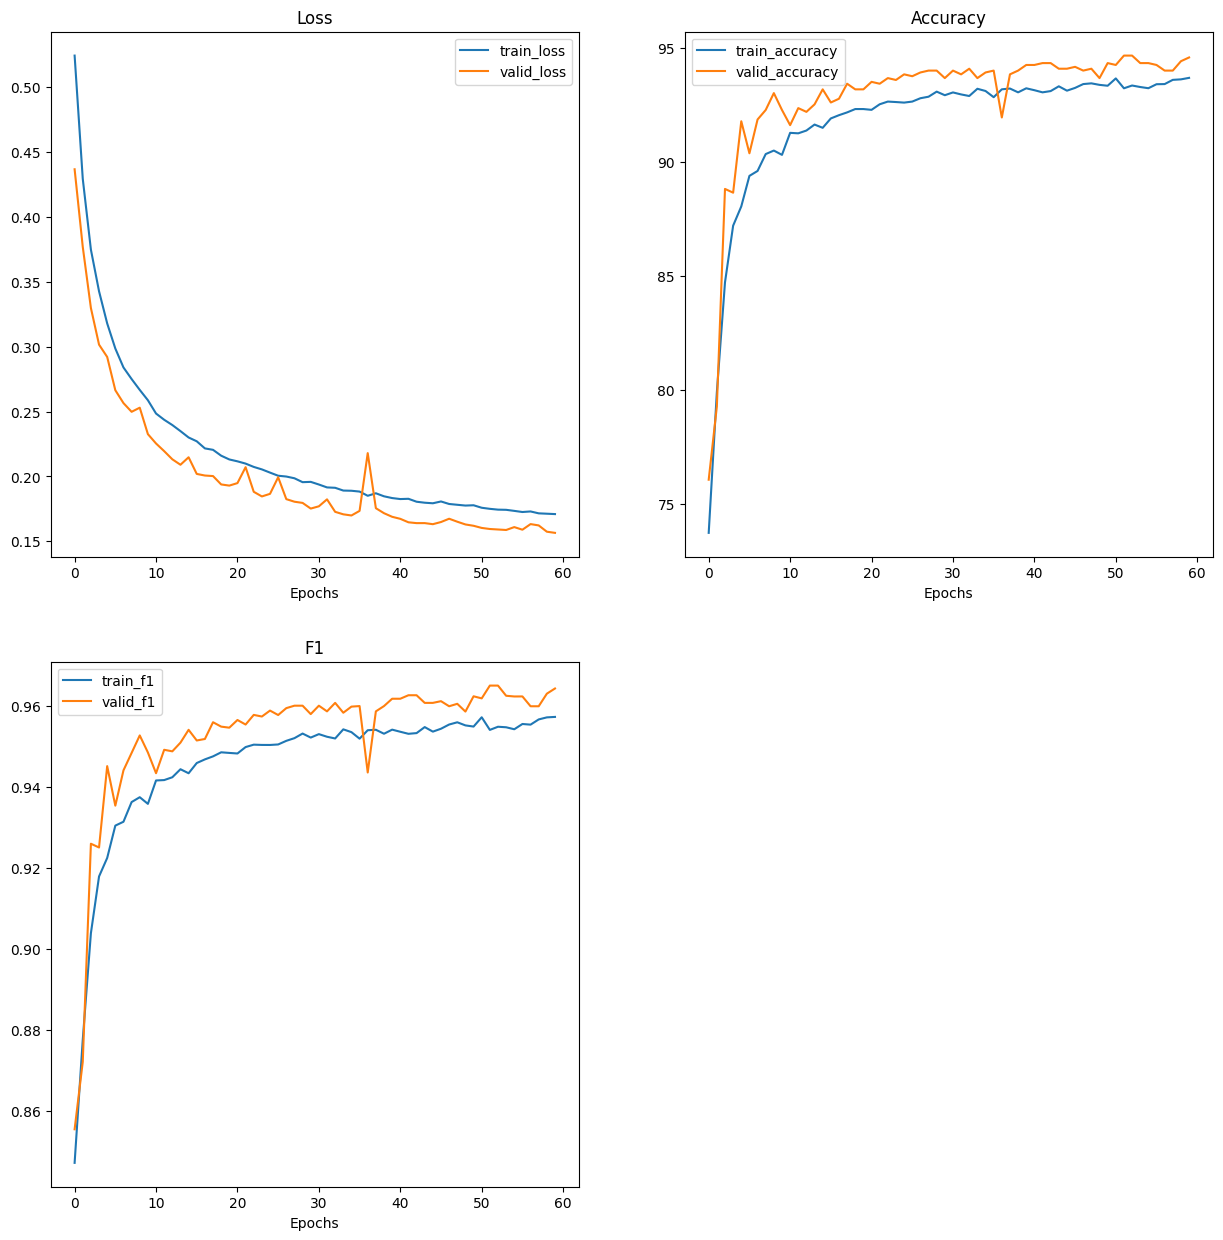

In [ ]:
# Linear
# Number of linear layers: 2
# Number of hidden units: 10
plot_loss_curves(model_20b_results)

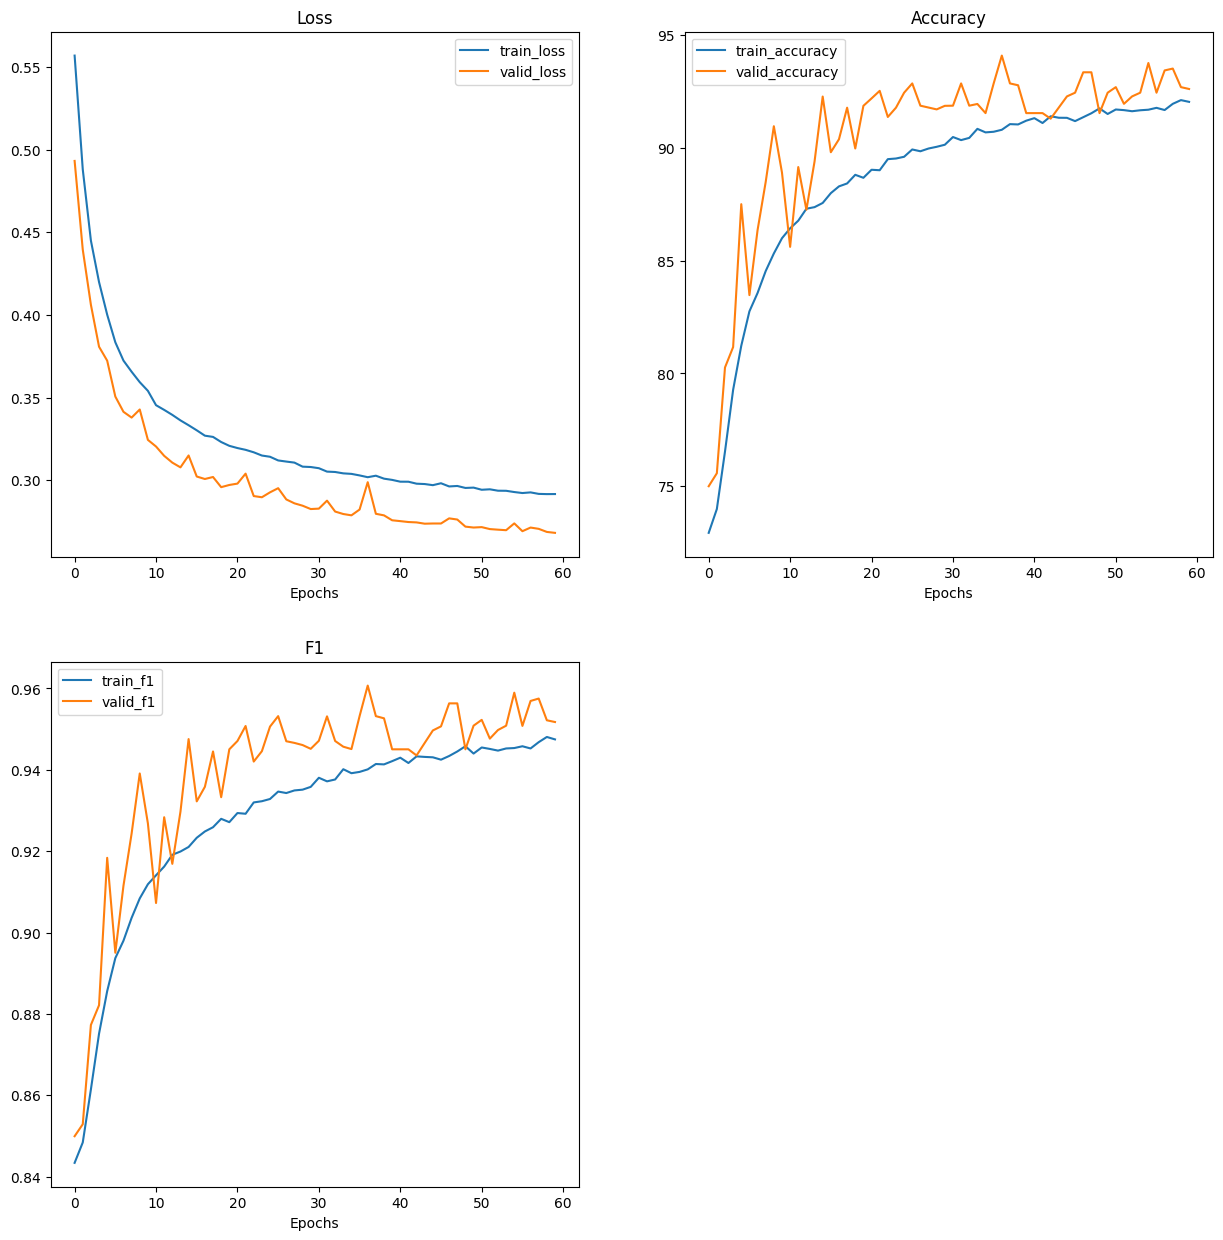

In [ ]:
# Linear + ReLU
# Number of linear layers: 2
# Number of hidden units: 10
plot_loss_curves(model_21b_results)

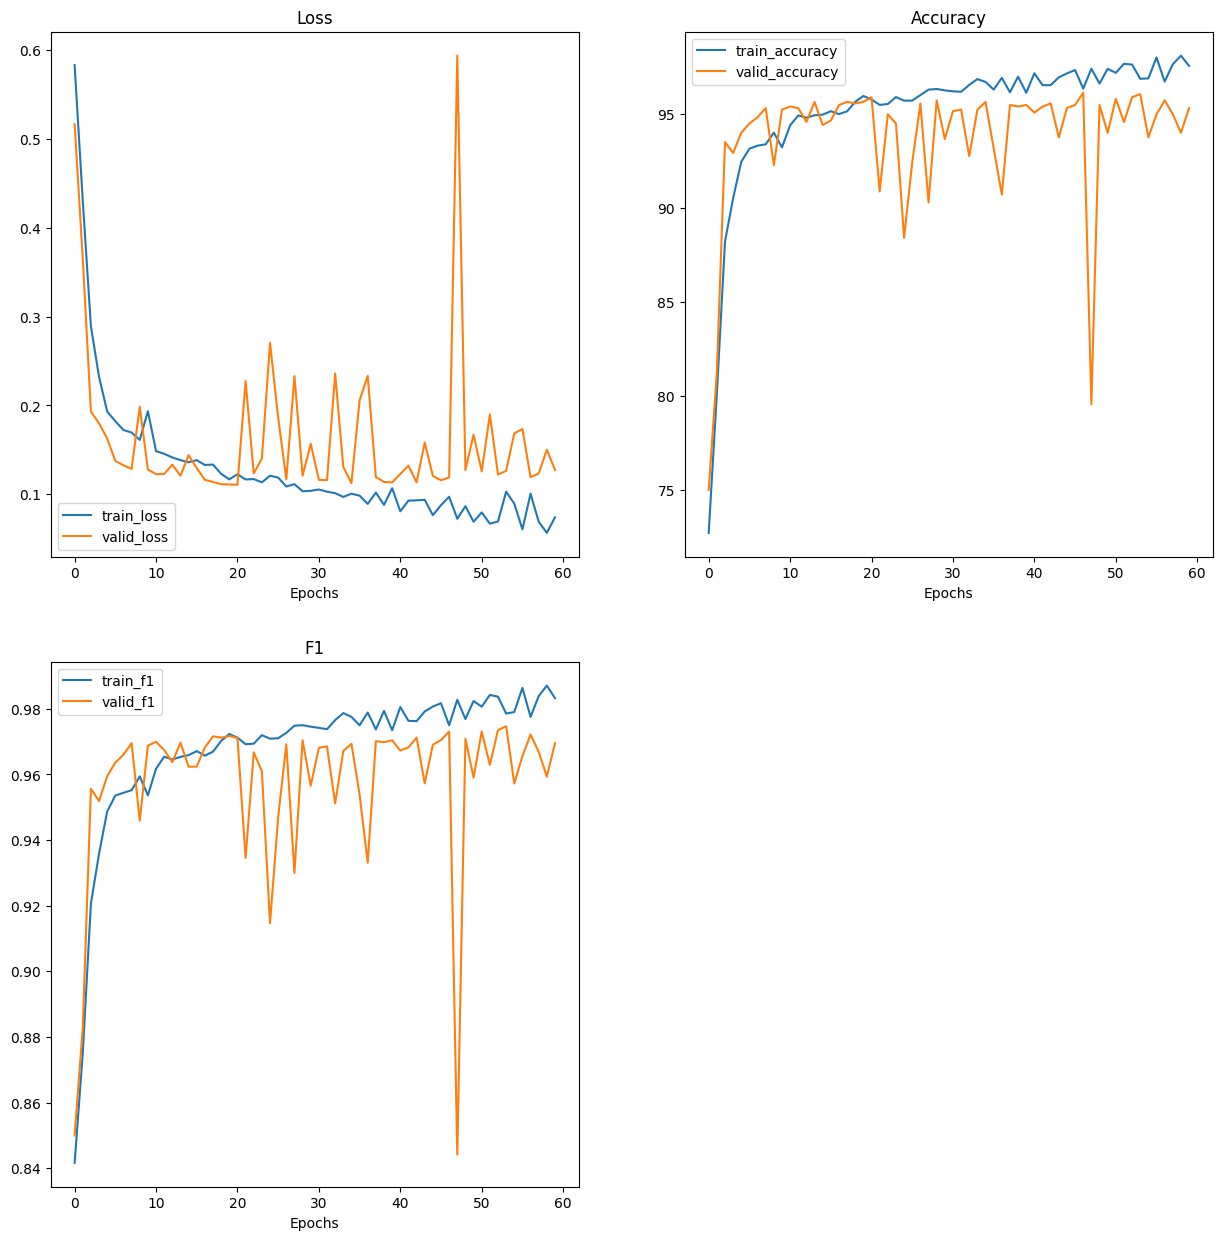

In [ ]:
# CNN
# Kernel size 3x3
# Number of hidden units: 10
plot_loss_curves(model_22b_results)

### b. Weighed loss function

#### Setting up models

In [30]:
#Linear
torch.manual_seed(42)
# Number of linear layers: 2
# Number of hidden units: 10
# Weighed
model_23b = XRAYS_linear2(input_shape=409600, # one for every pixel
    hidden_units=10, # how many units in the hidden layer
    output_shape=1
)
model_23b.to(device)

XRAYS_linear2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [31]:
optimizer_23b = torch.optim.SGD(params=model_23b.parameters(), lr=0.0001)

In [32]:
#Linear + ReLU
torch.manual_seed(42)

# Number of linear layers: 2
# Number of hidden units: 10
# Weighed
model_24b = XRAYS_linear2ReLU(input_shape=409600, # one for every pixel
    hidden_units=10, # how many units in the hidden layer
    output_shape=1
)
model_24b.to(device)

XRAYS_linear2ReLU(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=1, bias=True)
    (4): ReLU()
  )
)

In [33]:
optimizer_24b = torch.optim.SGD(params=model_24b.parameters(), lr=0.0001)

In [34]:
#CNN
torch.manual_seed(42)

# Kernel size 3x3
# Number of hidden units: 10
model_25b = XRAYS_CNN(input_shape=1, # 1 colour channel
    hidden_units=10, # how many filters
    output_shape=1
)
model_25b.to(device)

XRAYS_CNN(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256000, out_features=1, bias=True)
  )
)

In [35]:
optimizer_25b = torch.optim.SGD(params=model_25b.parameters(), lr=0.01)

#### Training

In [36]:
#Set number of epochs
NUM_EPOCHS = 60

In [37]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Linear
# Number of linear layers: 2
# Number of hidden units: 10
# Using weighed loss function

# Train model
model_23b_results = train(model=model_23b,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_23b,
                        loss_fn=loss_fn_weighed,
                        epochs=NUM_EPOCHS)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.34254 | Train accuracy: 67.19% | Train F1: 0.74
Validation loss: 0.29866 | Validation accuracy: 89.08%
 | Validation F1: 0.93
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.29218 | Train accuracy: 83.49% | Train F1: 0.88
Validation loss: 0.26050 | Validation accuracy: 90.38%
 | Validation F1: 0.93
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.25958 | Train accuracy: 85.52% | Train F1: 0.90
Validation loss: 0.23424 | Validation accuracy: 87.27%
 | Validation F1: 0.91
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.23860 | Train accuracy: 85.86% | Train F1: 0.90
Valida

In [42]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Linear + ReLU
# Number of linear layers: 2
# Number of hidden units: 10
# Using weighed loss function
# Train model
model_24b_results = train(model=model_24b,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_24b,
                        loss_fn=loss_fn_weighed,
                        epochs=NUM_EPOCHS)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.36893 | Train accuracy: 74.94% | Train F1: 0.85
Validation loss: 0.35105 | Validation accuracy: 77.88%
 | Validation F1: 0.86
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.35639 | Train accuracy: 78.82% | Train F1: 0.87
Validation loss: 0.33691 | Validation accuracy: 75.66%
 | Validation F1: 0.85
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.34045 | Train accuracy: 80.93% | Train F1: 0.88
Validation loss: 0.31715 | Validation accuracy: 85.77%
 | Validation F1: 0.91
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.32819 | Train accuracy: 82.91% | Train F1: 0.89
Valida

In [46]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# CNN
# Kernel size 3x3
# Number of hidden units: 10
# Using weighed loss function
# Train model
model_25b_results = train(model=model_25b,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_25b,
                        loss_fn=loss_fn_weighed,
                        epochs=NUM_EPOCHS)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.37399 | Train accuracy: 52.76% | Train F1: 0.62
Validation loss: 0.35415 | Validation accuracy: 82.66%
 | Validation F1: 0.87
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.32420 | Train accuracy: 76.32% | Train F1: 0.83
Validation loss: 0.28888 | Validation accuracy: 80.92%
 | Validation F1: 0.88
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.21195 | Train accuracy: 82.93% | Train F1: 0.88
Validation loss: 0.13415 | Validation accuracy: 89.08%
 | Validation F1: 0.92
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.15590 | Train accuracy: 87.85% | Train F1: 0.91
Valida

#### Results

In [38]:
# Linear
# Number of linear layers: 2
# Number of hidden units: 10
# Weighed
model_23b_results

{'train_loss': [0.34253645967692137,
  0.2921774999704212,
  0.2595786072779447,
  0.23859692667610943,
  0.22242857818491757,
  0.2093507689423859,
  0.1991962706670165,
  0.19226716575212777,
  0.18612330965697765,
  0.1804475432727486,
  0.1739981669234112,
  0.16996045515406877,
  0.16689739003777504,
  0.16340655728708953,
  0.16010686825029552,
  0.1575033739209175,
  0.15389190078713,
  0.15269844082649797,
  0.14979129249695688,
  0.14753131358884275,
  0.14620612235739827,
  0.1448473078198731,
  0.1427456954261288,
  0.14126012998167425,
  0.13969754287973046,
  0.13779486576095223,
  0.13719074160326272,
  0.1361564170802012,
  0.13425112946424633,
  0.13369458296801895,
  0.1324990662978962,
  0.13113689271267503,
  0.13051872607320547,
  0.12935095571447164,
  0.12888808932621032,
  0.12807023082859814,
  0.12642856477759778,
  0.1267233556136489,
  0.12562746205367148,
  0.12445901159662753,
  0.12397155887447298,
  0.12375601870007813,
  0.12241547892335802,
  0.12174861

In [43]:
# Linear + ReLU
# Number of linear layers: 2
# Number of hidden units: 10
# Weighed
model_24b_results

{'train_loss': [0.36893319757655263,
  0.3563882317394018,
  0.34044671431183815,
  0.3281866083852947,
  0.3187966856639832,
  0.30983306700363755,
  0.30359583301469684,
  0.29955259687267244,
  0.2957222245167941,
  0.29248941224068403,
  0.2874507149681449,
  0.2857286634389311,
  0.28370192064903677,
  0.2812196728773415,
  0.2798538326751441,
  0.2775468199979514,
  0.27588439430110157,
  0.27495164750143886,
  0.27334884577430785,
  0.27177063445560634,
  0.2708236298058182,
  0.26992542925290763,
  0.268801360623911,
  0.26763993315398693,
  0.2672007684595883,
  0.26591697661206126,
  0.26483268523588777,
  0.2643955028615892,
  0.2630598209798336,
  0.2625738463830203,
  0.26232168334536254,
  0.261023900937289,
  0.26050686184316874,
  0.26023029861971736,
  0.2597826053388417,
  0.2591372220776975,
  0.25896703475154936,
  0.2589685383718461,
  0.2578172557987273,
  0.25716860382817686,
  0.256773037603125,
  0.25640320405364037,
  0.2556590598542243,
  0.25567744276486337,

In [47]:
# CNN
# Number of linear layers: 1
# Number of hidden units: 10
# Weighed
model_25b_results

{'train_loss': [0.37399132642894983,
  0.32419814355671406,
  0.21195165463723242,
  0.1558999209664762,
  0.13278702407842502,
  0.12430831335950643,
  0.11835645011160523,
  0.11834192235255614,
  0.11177549415151589,
  0.11279142322018743,
  0.10196002008160576,
  0.0988780144834891,
  0.09728107909904793,
  0.09514647474861704,
  0.09439014829695225,
  0.09374522144207731,
  0.09061285000643693,
  0.09122379473410547,
  0.08663143671583384,
  0.08084437131765299,
  0.08409693272551522,
  0.08246338096796535,
  0.08017612504772842,
  0.07734583073761314,
  0.07738657262234483,
  0.07878913637250662,
  0.07411219671485014,
  0.07629897713195533,
  0.07223750144476071,
  0.07192978504463099,
  0.07598697682260536,
  0.06971522301319055,
  0.06945491561782546,
  0.06830199281102978,
  0.06966958229895681,
  0.06492718459048774,
  0.06299668399151415,
  0.06583812335156836,
  0.05981767812045291,
  0.06660112313693389,
  0.05754303903086111,
  0.060701878668623976,
  0.06331249176582787

#### Graphs

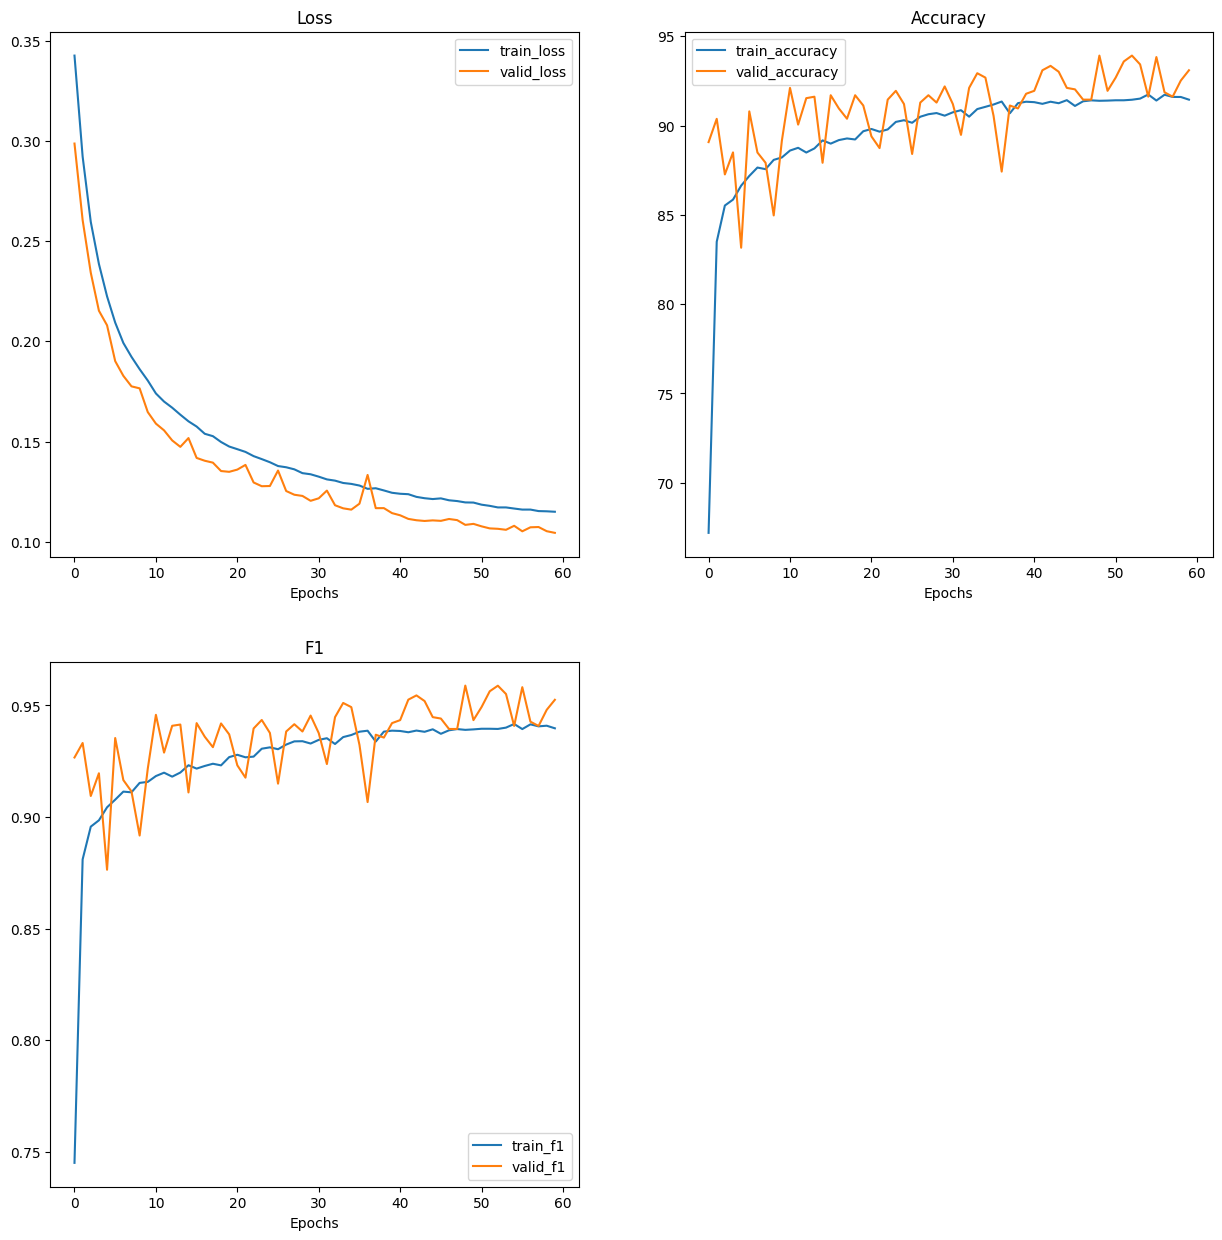

In [39]:
# Linear
# Number of linear layers: 2
# Number of hidden units: 10
# Weighed
plot_loss_curves(model_23b_results)

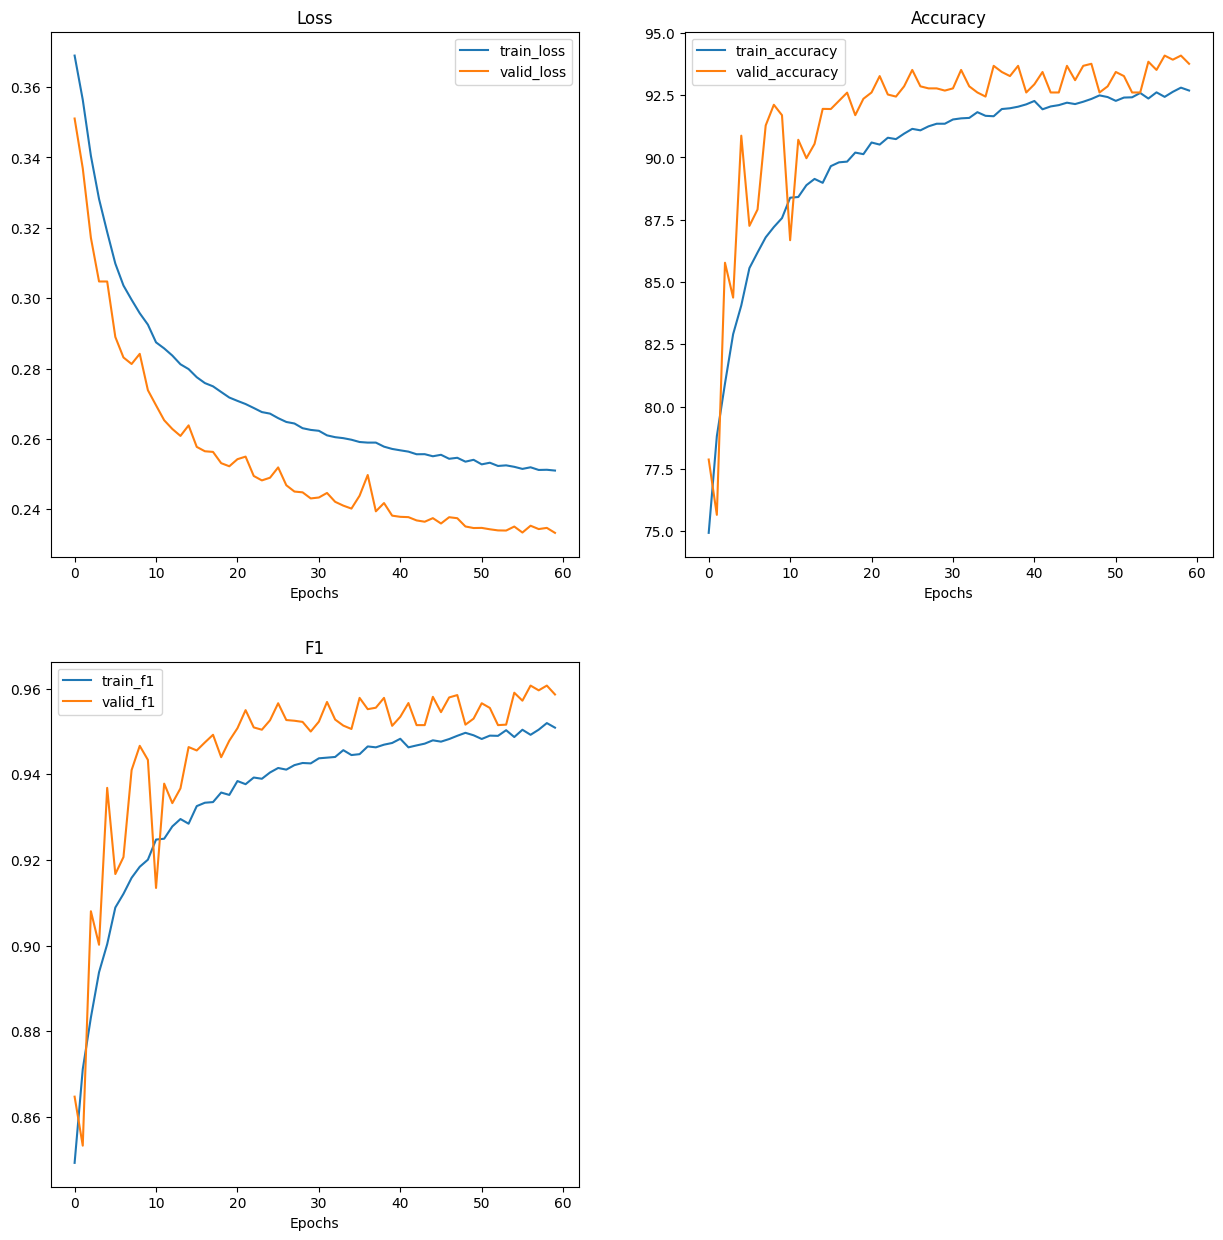

In [44]:
# Linear + ReLU
# Number of linear layers: 2
# Number of hidden units: 10
# Weighed
plot_loss_curves(model_24b_results)

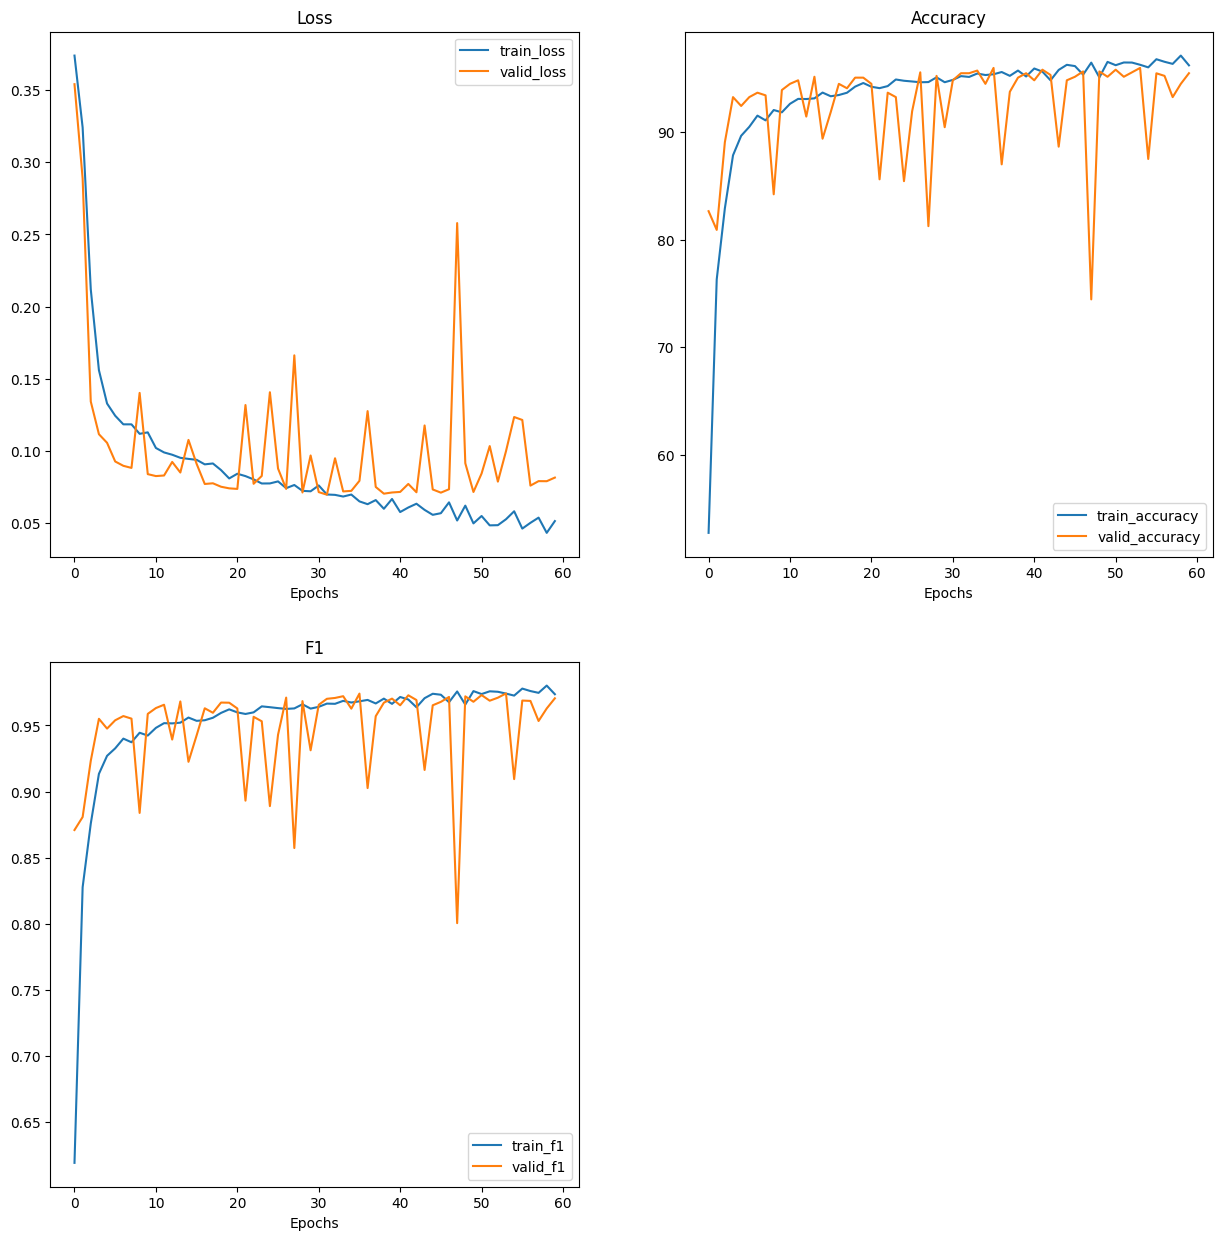

In [48]:
# CNN
# Number of linear layers: 1
# Number of hidden units: 10
# Weighed
plot_loss_curves(model_25b_results)

## 7. Saving models

In [40]:
# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

In [ ]:
# 2. Create model save path
MODEL_NAME = "model_20b.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_20b.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/model_20b.pth


In [ ]:
# 2. Create model save path
MODEL_NAME = "model_21b.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_21b.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/model_21b.pth


In [ ]:
# 2. Create model save path
MODEL_NAME = "model_22b.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_22b.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/model_22b.pth


In [41]:
# 2. Create model save path
MODEL_NAME = "model_23b.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_23b.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/model_23b.pth


In [45]:
# 2. Create model save path
MODEL_NAME = "model_24b.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_24b.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/model_24b.pth


In [49]:
# 2. Create model save path
MODEL_NAME = "model_25b.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_25b.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/model_25b.pth


## 8. Evaluation

### Linear models

#### Model 20b

In [93]:
loaded_model_20b = XRAYS_linear2(input_shape=409600,
    hidden_units=10,
    output_shape=1)

loaded_model_20b.to(device)

# Load model state dict
loaded_model_20b.load_state_dict(torch.load('models/model_20b.pth', map_location=torch.device(device)))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_20b.to(device)

print(f"Loaded model:\n{loaded_model_20b}")
print(f"Model on device:\n{next(loaded_model_20b.parameters()).device}")


Loaded model:
XRAYS_linear2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)
Model on device:
cuda:0


In [94]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Testing
test_results_model_20b, y_test, y_test_pred_model_20b = test(data_loader=test_dataloader,
                                                            model=loaded_model_20b,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [95]:
test_results_model_20b

{'test_acc': 91.77083333333334, 'test_f1': 0.948626045400239}

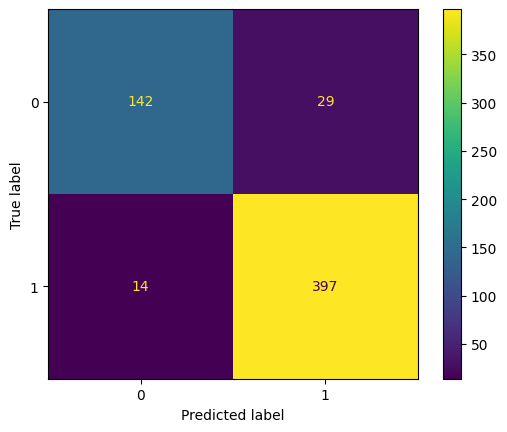

In [96]:
cm = confusion_matrix(y_test, y_test_pred_model_20b)
ConfusionMatrixDisplay(cm).plot()

#### Model 23 (weighed loss function)

In [97]:
loaded_model_23b = XRAYS_linear2(input_shape=409600,
    hidden_units=10,
    output_shape=1)

loaded_model_23b.to(device)

# Load model state dict
loaded_model_23b.load_state_dict(torch.load('models/model_23b.pth', map_location=torch.device(device)))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_23b.to(device)

print(f"Loaded model:\n{loaded_model_23b}")
print(f"Model on device:\n{next(loaded_model_23b.parameters()).device}")


Loaded model:
XRAYS_linear2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)
Model on device:
cuda:0


In [98]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Testing
test_results_model_23b, y_test, y_test_pred_model_23b = test(data_loader=test_dataloader,
                                                            model=loaded_model_23b,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [99]:
test_results_model_23b

{'test_acc': 90.20833333333334, 'test_f1': 0.9338327091136079}

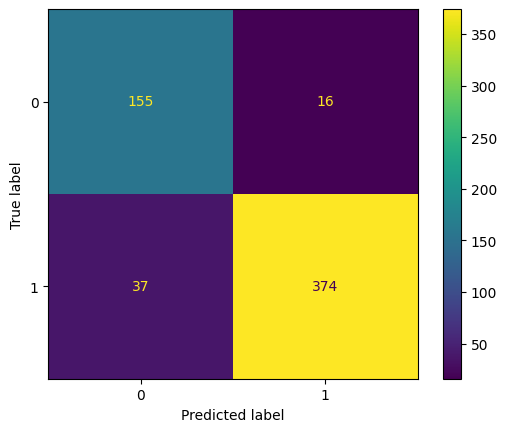

In [100]:
cm = confusion_matrix(y_test, y_test_pred_model_23b)
ConfusionMatrixDisplay(cm).plot()

### Linear + ReLU models

#### Model 21

In [101]:
loaded_model_21b = XRAYS_linear2ReLU(input_shape=409600,
    hidden_units=10,
    output_shape=1)

# Load model state dict
loaded_model_21b.load_state_dict(torch.load('models/model_21b.pth', map_location=torch.device(device)))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_21b.to(device)

print(f"Loaded model:\n{loaded_model_21b}")
print(f"Model on device:\n{next(loaded_model_21b.parameters()).device}")

Loaded model:
XRAYS_linear2ReLU(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=1, bias=True)
    (4): ReLU()
  )
)
Model on device:
cuda:0


In [102]:
test_results_model_21b, y_test, y_test_pred_model_21b = test(data_loader=test_dataloader,
                                                            model=loaded_model_21b,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [103]:
test_results_model_21b

{'test_acc': 93.125, 'test_f1': 0.9484777517564402}

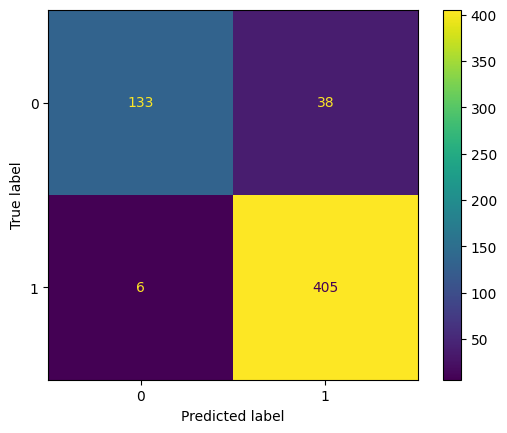

In [104]:
cm = confusion_matrix(y_test, y_test_pred_model_21b)
ConfusionMatrixDisplay(cm).plot()

#### Model 24 (weighed loss function)

In [105]:
loaded_model_24b = XRAYS_linear2ReLU(input_shape=409600,
    hidden_units=10,
    output_shape=1)

# Load model state dict
loaded_model_24b.load_state_dict(torch.load('models/model_24b.pth', map_location=torch.device(device)))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_24b.to(device)

print(f"Loaded model:\n{loaded_model_24b}")
print(f"Model on device:\n{next(loaded_model_24b.parameters()).device}")

Loaded model:
XRAYS_linear2ReLU(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=1, bias=True)
    (4): ReLU()
  )
)
Model on device:
cuda:0


In [106]:
test_results_model_24b, y_test, y_test_pred_model_24b = test(data_loader=test_dataloader,
                                                            model=loaded_model_24b,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [107]:
test_results_model_24b

{'test_acc': 93.28125, 'test_f1': 0.9483793517406963}

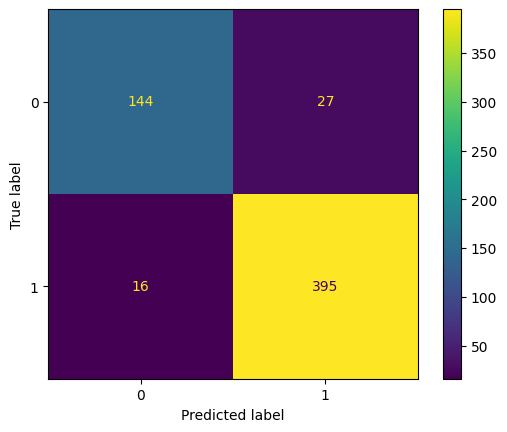

In [108]:
cm = confusion_matrix(y_test, y_test_pred_model_24b)
ConfusionMatrixDisplay(cm).plot()

### CNN models

#### Model 22

In [109]:
loaded_model_22b = XRAYS_CNN(input_shape=1,
    hidden_units=10,
    output_shape=1
)

loaded_model_22b.to(device)
# Load model state dict
loaded_model_22b.load_state_dict(torch.load('models/model_22b.pth', map_location=torch.device(device) ))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_22b.to(device)

print(f"Loaded model:\n{loaded_model_22b}")
print(f"Model on device:\n{next(loaded_model_22b.parameters()).device}")

Loaded model:
XRAYS_CNN(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256000, out_features=1, bias=True)
  )
)
Model on device:
cuda:0


In [110]:
test_results_model_22b, y_test, y_test_pred_model_22b = test(data_loader=test_dataloader,
                                                            model=loaded_model_22b,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [111]:
test_results_model_22b

{'test_acc': 92.39583333333334, 'test_f1': 0.9532934131736528}

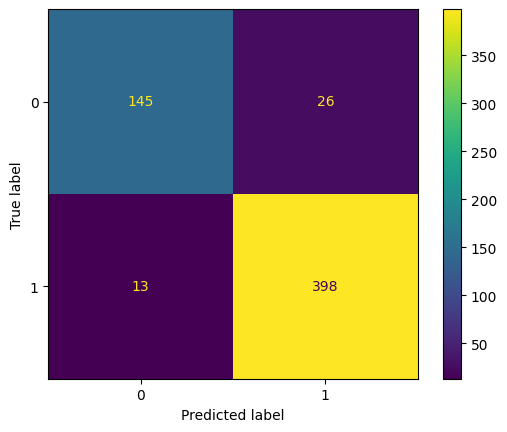

In [112]:
cm = confusion_matrix(y_test, y_test_pred_model_22b)
ConfusionMatrixDisplay(cm).plot()

#### Model 25 (weighed loss function)

In [113]:
loaded_model_25b = XRAYS_CNN(input_shape=1,
    hidden_units=10,
    output_shape=1
)

loaded_model_25b.to(device)
# Load model state dict
loaded_model_25b.load_state_dict(torch.load('models/model_25b.pth', map_location=torch.device(device) ))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_25b.to(device)

print(f"Loaded model:\n{loaded_model_25b}")
print(f"Model on device:\n{next(loaded_model_25b.parameters()).device}")

Loaded model:
XRAYS_CNN(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256000, out_features=1, bias=True)
  )
)
Model on device:
cuda:0


In [114]:
test_results_model_25b, y_test, y_test_pred_model_25b = test(data_loader=test_dataloader,
                                                            model=loaded_model_25b,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [115]:
test_results_model_25b

{'test_acc': 92.23958333333334, 'test_f1': 0.9515738498789347}

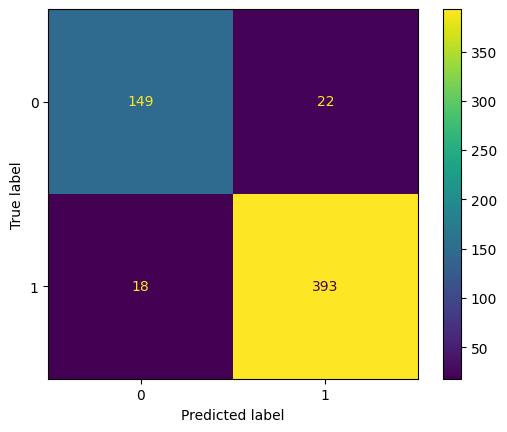

In [116]:
cm = confusion_matrix(y_test, y_test_pred_model_25b)
ConfusionMatrixDisplay(cm).plot()